# Step 3: Prepare Risk Features by Administrative Zone

This notebook aggregates geospatial indicators by parish-level administrative zones in Kampala, Uganda. These indicators include vegetation health (NDVI), infrastructure density (buildings and roads), and access to public services (schools, clinics, hospitals).

These features form the basis for spatial vulnerability analysis and mapping.


In [3]:
import geopandas as gpd
import rasterio
import rasterstats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point


## Load Parish Boundaries and Filter for Kampala

We load the ADM4 shapefile (parishes) and filter only those in the Kampala District.


Number of parishes: 5


<Axes: >

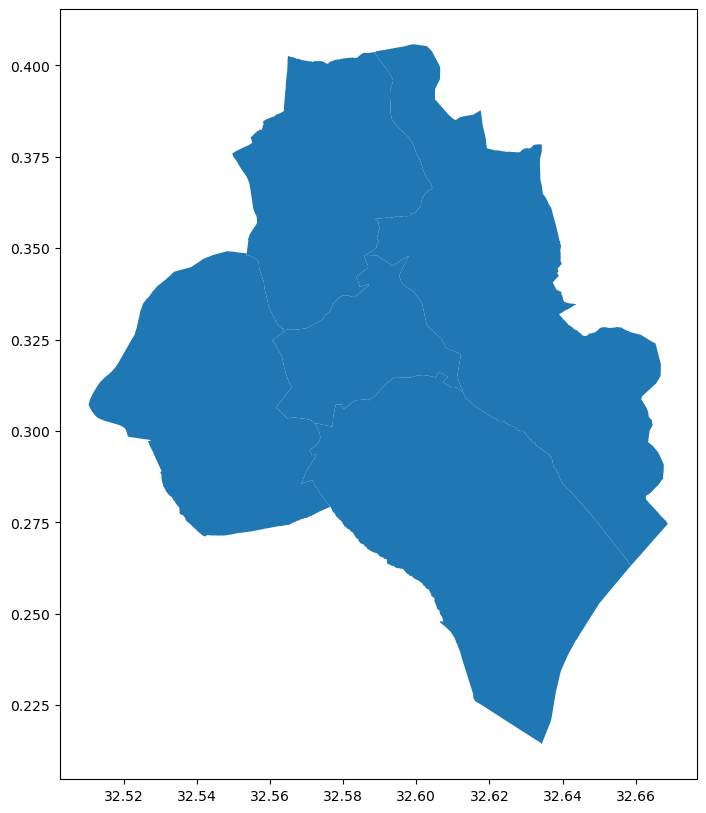

In [9]:
admin_path = "../data/raw/kampala_admin_boundaries/uga_admbnda_adm4_ubos_20200824.shp"
gdf = gpd.read_file(admin_path)

# Filter for Kampala
kampala_parishes = gdf[gdf["ADM2_EN"].str.lower() == "kampala"].copy()
kampala_parishes = kampala_parishes.to_crs("EPSG:4326")

print("Number of parishes:", len(kampala_parishes))
kampala_parishes.plot(figsize=(10, 10))


## NDVI Aggregation by Parish

In this step, we calculate the average NDVI value for each parish in Kampala using zonal statistics. This helps identify areas with low vegetation cover, which may be more vulnerable to heat or flooding.


In [13]:
# Keep only useful columns (ADM4_EN and geometry)
kampala_for_stats = kampala_parishes[["ADM4_EN", "geometry"]].copy()

# Compute zonal stats using JSON-safe version
stats = zonal_stats(
    kampala_for_stats.to_json(),  # safe for rasterstats
    "../data/raw/Kawempe_NDVI_2023.tif",
    stats=["mean"],
    geojson_out=True
)

# Convert to GeoDataFrame
kampala_ndvi = gpd.GeoDataFrame.from_features(stats)
kampala_ndvi = kampala_ndvi.set_crs("EPSG:4326")
kampala_ndvi = kampala_ndvi.rename(columns={"mean": "mean_ndvi"})


## Load Infrastructure and Services Layers

We now load building footprints, road segments, and public services (clinics, schools, hospitals) extracted from OpenStreetMap. These layers will be used to compute structural and access-related risk indicators per parish.


In [15]:
# Load raw GeoJSON files
buildings = gpd.read_file("../data/raw/kawempe_buildings.geojson").to_crs("EPSG:4326")
roads = gpd.read_file("../data/raw/kawempe_highways.geojson").to_crs("EPSG:4326")
services = gpd.read_file("../data/raw/kawempe_services.geojson").to_crs("EPSG:4326")

print("Loaded features:")
print(" - Buildings:", len(buildings))
print(" - Roads:", len(roads))
print(" - Services:", len(services))


Loaded features:
 - Buildings: 100181
 - Roads: 3060
 - Services: 667


## Count Buildings and Services per Parish

We count the number of building footprints and service points within each parish.
This helps identify areas with limited access to physical infrastructure or public amenities.


In [16]:
# Spatial join: buildings within each parish
bldg_join = gpd.sjoin(buildings, kampala_ndvi, predicate="within")
building_counts = bldg_join.groupby("ADM4_EN").size().reset_index(name="building_count")


In [17]:
# Spatial join: services within each parish
svc_join = gpd.sjoin(services, kampala_ndvi, predicate="within")
service_counts = svc_join.groupby("ADM4_EN").size().reset_index(name="service_count")


## Compute Total Road Length per Parish

We compute the total length of roads (in kilometers) within each parish.
Higher road coverage may indicate better physical connectivity and emergency access potential.


In [18]:
# Reproject roads to UTM zone for accurate length calculation (meters)
# UTM Zone 36N covers Kampala (EPSG:32636)
roads_projected = roads.to_crs("EPSG:32636")
roads_projected["length_km"] = roads_projected.length / 1000  # meters to km

# Join with parish boundaries (also reprojected to EPSG:32636)
parishes_projected = kampala_ndvi.to_crs("EPSG:32636")
road_join = gpd.sjoin(roads_projected, parishes_projected, predicate="within")
road_length = road_join.groupby("ADM4_EN")["length_km"].sum().reset_index()


## Admin Zone File Information

In [27]:
gdf1 = gpd.read_file("../data/raw/kampala_admin_boundaries/uga_admbnda_adm1_ubos_20200824.shp")
print("ADM1 (Regions):", gdf1["ADM1_EN"].unique())
print("Number of rows:", len(gdf1))


ADM1 (Regions): ['Central' 'Eastern' 'Northern' 'Western']
Number of rows: 4


In [28]:
gdf2 = gpd.read_file("../data/raw/kampala_admin_boundaries/uga_admbnda_adm2_ubos_20200824.shp")
print("ADM2 (Districts):", gdf2["ADM2_EN"].unique())
print("Number of rows:", len(gdf2))


ADM2 (Districts): ['Abim' 'Adjumani' 'Agago' 'Alebtong' 'Amolatar' 'Amudat' 'Amuria' 'Amuru'
 'Apac' 'Arua' 'Budaka' 'Bududa' 'Bugiri' 'Bugweri' 'Buhweju' 'Buikwe'
 'Bukedea' 'Bukomansimbi' 'Bukwo' 'Bulambuli' 'Buliisa' 'Bundibugyo'
 'Bunyangabu' 'Bushenyi' 'Busia' 'Butaleja' 'Butambala' 'Butebo' 'Buvuma'
 'Buyende' 'Dokolo' 'Gomba' 'Gulu' 'Hoima' 'Ibanda' 'Iganga' 'Isingiro'
 'Jinja' 'Kaabong' 'Kabale' 'Kabarole' 'Kaberamaido' 'Kagadi' 'Kakumiro'
 'Kalaki' 'Kalangala' 'Kaliro' 'Kalungu' 'Kampala' 'Kamuli' 'Kamwenge'
 'Kanungu' 'Kapchorwa' 'Kapelebyong' 'Karenga' 'Kasese' 'Kassanda'
 'Katakwi' 'Kayunga' 'Kazo' 'Kibaale' 'Kiboga' 'Kibuku' 'Kikuube'
 'Kiruhura' 'Kiryandongo' 'Kisoro' 'Kitagwenda' 'Kitgum' 'Koboko' 'Kole'
 'Kotido' 'Kumi' 'Kwania' 'Kween' 'Kyankwanzi' 'Kyegegwa' 'Kyenjojo'
 'Kyotera' 'Lamwo' 'Lira' 'Luuka' 'Luwero' 'Lwengo' 'Lyantonde'
 'Madi Okollo' 'Manafwa' 'Maracha' 'Masaka' 'Masindi' 'Mayuge' 'Mbale'
 'Mbarara' 'Mitooma' 'Mityana' 'Moroto' 'Moyo' 'Mpigi' 'Mubende' 'M

In [29]:
gdf3 = gpd.read_file("../data/raw/kampala_admin_boundaries/uga_admbnda_adm3_ubos_20200824.shp")
print("ADM3 (Divisions):", gdf3["ADM3_EN"].unique())
print("Number of rows:", len(gdf3))


ADM3 (Divisions): ['Agago' 'Amuria' 'Apac Municipality' 'Aringa' 'Arua Municipality' 'Aruu'
 'Aswa' 'Ayivu' 'Bamunanika' 'Bbaale' 'Bokora' 'Bubulo' 'Budadiri'
 'Budaka' 'Budiope' 'Bufumbira' 'Bugabula' 'Bugahya' 'Bugangaizi'
 'Bughendera' 'Bugiri Municipality' 'Bugweri' 'Buhaguzi' 'Buhweju'
 'Buikwe' 'Bujenje' 'Bujumba' 'Bujumbura' 'Bukanga' 'Bukedea'
 'Bukomansimbi' 'Bukonjo' 'Bukooli' 'Bukoto' 'Bulambuli' 'Bulamogi'
 'Buliisa' 'Bungokho' 'Bunya' 'Bunyangabu' 'Bunyaruguru' 'Bunyole'
 'Burahya' 'Buruli' 'Buruuli' 'Bushenyi  Municipality'
 'Busia Municipality' 'Busiki' 'Busiro' 'Busongora' 'Busujju' 'Butambala'
 'Butebo' 'Butembe' 'Buvuma Island' 'Buwekula' 'Buyaga' 'Buyanja'
 'Buzaaya' 'Bwamba' 'Chekwi' 'Chua' 'Dodoth' 'Dokolo' 'East Moyo'
 'Entebbe Municipality' 'Erute' 'Fort Portal Municipality' 'Gomba'
 'Gulu Municipality' 'Hoima Municipality' 'Ibanda' 'Ibanda Municipality'
 'Iganga Municipality' 'Igara' 'Iki-Iki' 'Isingiro' 'Jie'
 'Jinja Municipality' 'Jonam' 'Kabale Municipality' 

In [30]:
gdf4 = gpd.read_file("../data/raw/kampala_admin_boundaries/uga_admbnda_adm4_ubos_20200824.shp")
print("ADM4 (Parishes):", gdf4["ADM4_EN"].unique()[:10])  # just preview a few
print("Sample ADM2:", gdf4["ADM2_EN"].unique())
print("Sample ADM3:", gdf4["ADM3_EN"].unique())
print("Number of rows:", len(gdf4))


ADM4 (Parishes): ['Abako' 'Abanga' 'Abarilela' 'Aber' 'Abia' 'Abim' 'Abim Town Council'
 'Abindu Division' 'Abok' 'Aboke']
Sample ADM2: ['Alebtong' 'Zombo' 'Amuria' 'Oyam' 'Abim' 'Nebbi' 'Kole' 'Kwania'
 'Koboko' 'Pader' 'Kapelebyong' 'Dokolo' 'Lira' 'Agago' 'Adjumani' 'Arua'
 'Otuke' 'Amolatar' 'Lamwo' 'Pallisa' 'Apac' 'Nwoya' 'Obongi'
 'Kaberamaido' 'Pakwach' 'Amudat' 'Kapchorwa' 'Amuru' 'Kalaki'
 'Madi Okollo' 'Yumbe' 'Soroti' 'Serere' 'Kumi' 'Gulu' 'Mubende' 'Mayuge'
 'Kamuli' 'Luwero' 'Kyankwanzi' 'Namayingo' 'Kayunga' 'Mityana' 'Kween'
 'Bukomansimbi' 'Kamwenge' 'Buhweju' 'Mbarara' 'Buliisa' 'Kakumiro'
 'Isingiro' 'Ibanda' 'Mitooma' 'Bushenyi' 'Omoro' 'Rubanda' 'Bundibugyo'
 'Kibaale' 'Kalangala' 'Bududa' 'Namisindwa' 'Mbale' 'Sironko' 'Budaka'
 'Butambala' 'Bugiri' 'Kaliro' 'Jinja' 'Masindi' 'Butaleja' 'Kyenjojo'
 'Rwampara' 'Kikuube' 'Rukungiri' 'Buvuma' 'Buyende' 'Bulambuli' 'Manafwa'
 'Sheema' 'Kasese' 'Bugweri' 'Kitagwenda' 'Hoima' 'Kabale' 'Bunyangabu'
 'Busia' 'Buikwe' 'Ma

## Merge All Risk Indicators into a Single GeoDataFrame

We combine NDVI, building count, service count, and road length into one layer. This dataset can be used for spatial analysis, visualizations, and machine learning in later steps.


In [19]:
# Start with NDVI GeoDataFrame
features = kampala_ndvi[["ADM4_EN", "geometry", "mean_ndvi"]].copy()

# Merge building count
features = features.merge(building_counts, on="ADM4_EN", how="left")

# Merge service count
features = features.merge(service_counts, on="ADM4_EN", how="left")

# Merge road length
features = features.merge(road_length, on="ADM4_EN", how="left")

# Fill missing values with 0 (for parishes that had no data)
features[["building_count", "service_count", "length_km"]] = features[["building_count", "service_count", "length_km"]].fillna(0)

features.head()


,ADM4_EN,geometry,mean_ndvi,building_count,service_count,length_km
0,Central Division,"POLYGON ((32.56389 0.32727, 32.5642 0.32748, 3...",0.138465,93.0,2.0,0.508057
1,Kawempe Division,"POLYGON ((32.58866 0.4036, 32.5891 0.40264, 32...",0.125886,99374.0,660.0,404.083746
2,Makindye Division,"POLYGON ((32.61277 0.31065, 32.6129 0.31034, 3...",0.000000,0.0,0.0,0.000000
3,Nakawa Division,"POLYGON ((32.61004 0.3854, 32.61072 0.385, 32....",0.086226,305.0,4.0,6.877218
4,Rubaga Division,"POLYGON ((32.52114 0.29848, 32.52113 0.29848, ...",0.043537,288.0,1.0,1.895823


## Save Processed Features to File

We export the final features GeoDataFrame to GeoJSON for use in maps, reports, or further analysis.


In [21]:
features.to_file("../data/processed/kampala_risk_features.geojson", driver="GeoJSON")
print("Saved to ../data/processed/kampala_risk_features.geojson")


Saved to ../data/processed/kampala_risk_features.geojson


## Quick Visualization of Risk Indicators

We preview the spatial distribution of NDVI and infrastructure indicators using simple maps.


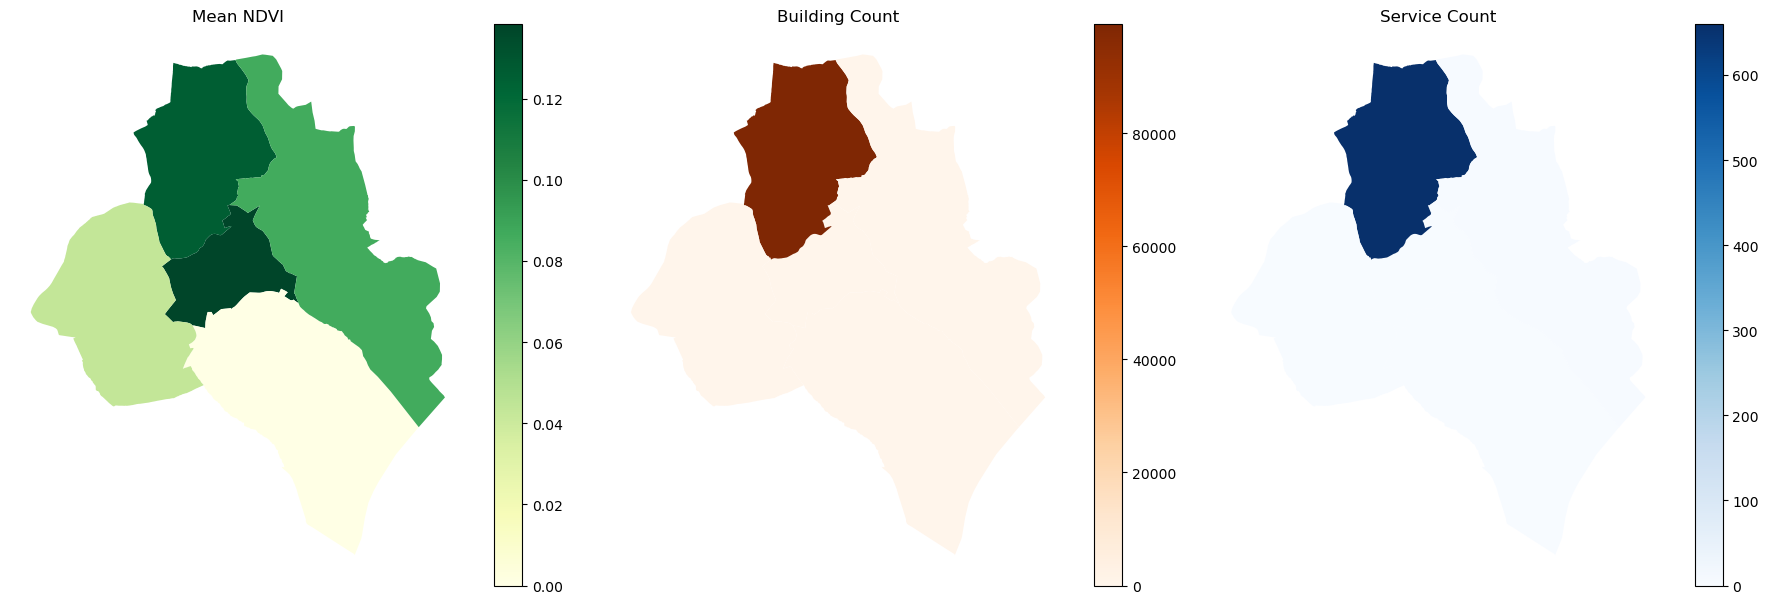

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

features.plot(column="mean_ndvi", cmap="YlGn", legend=True, ax=axs[0])
axs[0].set_title("Mean NDVI")

features.plot(column="building_count", cmap="Oranges", legend=True, ax=axs[1])
axs[1].set_title("Building Count")

features.plot(column="service_count", cmap="Blues", legend=True, ax=axs[2])
axs[2].set_title("Service Count")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


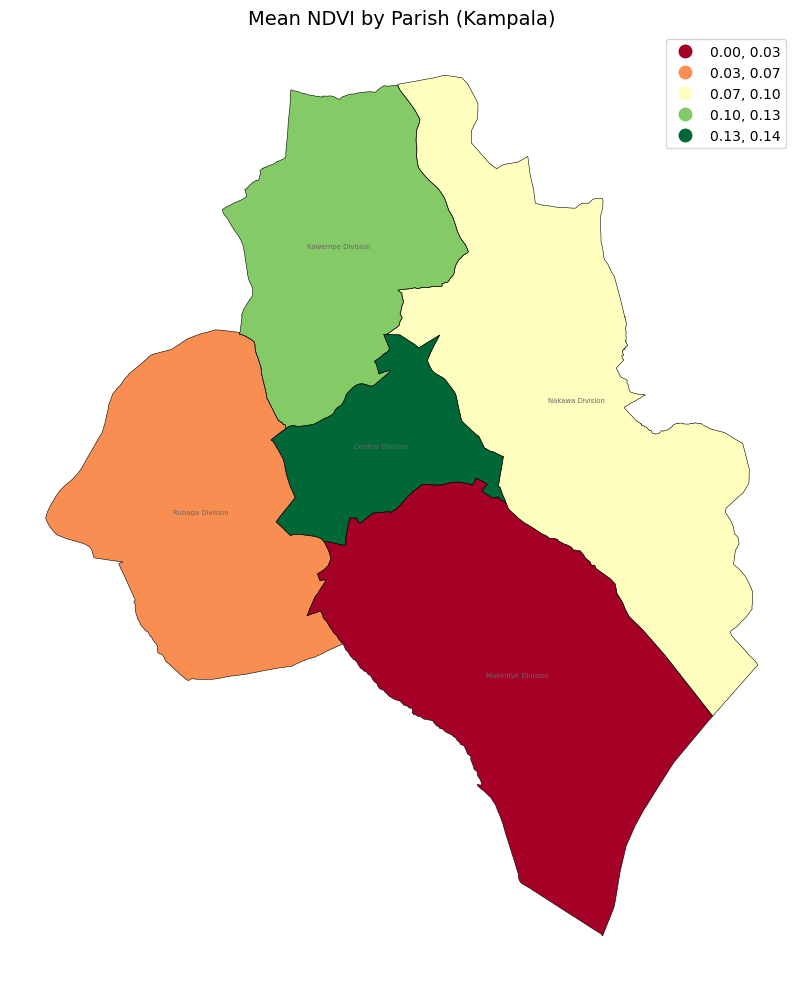

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

# Plot parish boundaries
features.boundary.plot(ax=ax, color="black", linewidth=0.4)

# Plot NDVI with quantile classification (no invalid legend_kwds)
features.plot(
    column="mean_ndvi",
    cmap="RdYlGn",
    scheme="quantiles",
    k=5,
    legend=True,
    ax=ax
)

# Label each parish
for idx, row in features.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["ADM4_EN"], fontsize=5, ha='center', color='dimgray')

ax.set_title("Mean NDVI by Parish (Kampala)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [26]:
# Extract ADM3 division name from original shapefile
adm3_lookup = gdf[["ADM4_EN", "ADM3_EN"]]
features = features.merge(adm3_lookup, on="ADM4_EN", how="left")

# Filter to only parishes in Kawempe Division
kawempe_features = features[features["ADM3_EN"].str.lower() == "kawempe"].copy()

print("Kawempe parishes:", len(kawempe_features))


Kawempe parishes: 0
